Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                82332 non-null  float32 
 1   proto              82332 non-null  category
 2   service            82332 non-null  category
 3   state              82332 non-null  category
 4   spkts              82332 non-null  int16   
 5   dpkts              82332 non-null  int16   
 6   sbytes             82332 non-null  int32   
 7   dbytes             82332 non-null  int32   
 8   rate               82332 non-null  float32 
 9   sload              82332 non-null  float32 
 10  dload              82332 non-null  float32 
 11  sloss              82332 non-null  int16   
 12  dloss              82332 non-null  int16   
 13  sinpkt             82332 non-null  float32 
 14  dinpkt             82332 non-null  float32 
 15  sjit               82332 non-null  floa

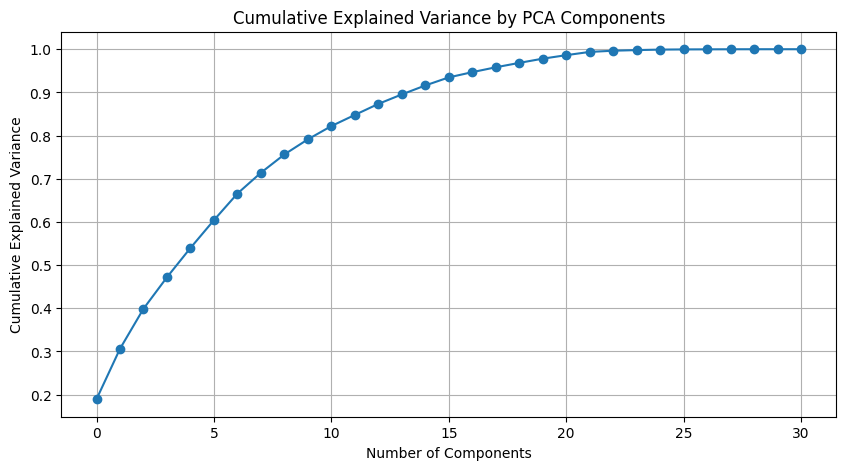

Number of components to retain 90% variance: 15


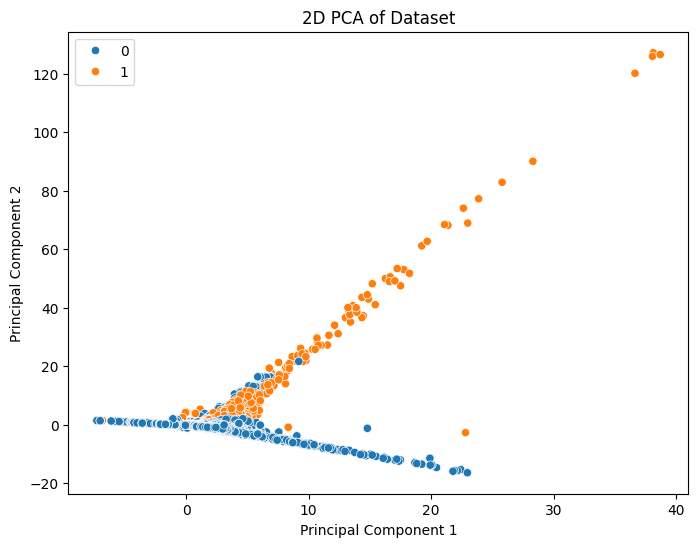


Total variance retained by the first 15 principal components: 91.61%

Interpretation:
PCA was able to reduce the dimensionality of the dataset significantly while retaining most of the variance.
This reduced dataset could be used in various cybersecurity applications:
1. Anomaly Detection: PCA-transformed data may reveal deviations from normal patterns, enabling quicker identification of unusual activity.
2. Malware Classification: Reduced dimensions simplify models, allowing for faster, real-time classification.
3. Resource Efficiency: Fewer dimensions lead to lower memory usage and faster processing, ideal for real-time applications.

Limitations:
PCA is a linear technique, so it may not capture non-linear patterns in the data. For complex cybersecurity datasets with non-linear patterns,
combining PCA with non-linear techniques or using Kernel PCA might be more effective.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_parquet('/content/UNSW_NB15_testing-set.parquet')

# Separate the target label if present
target_label = df['label'] if 'label' in df.columns else None
df_features = df.drop(columns=['label']) if target_label is not None else df

# Inspect the dataset
print("Dataset Info:")
print(df.info())
print("\nDataset Head:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

# Standardize the features and handle non-numeric data using ColumnTransformer (OneHotEncoder and StandardScaler)
non_numeric_columns = df_features.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), df_features.select_dtypes(include=[np.number]).columns),
        ('cat', OneHotEncoder(), non_numeric_columns)
    ]
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA())
])

# Fit and transform the data with PCA
X_preprocessed = pipeline.named_steps['preprocessing'].fit_transform(df_features)
pipeline.named_steps['pca'].fit(X_preprocessed)

# Explained variance ratio and cumulative variance
explained_variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Selecting the optimal number of components to retain 90% variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

# Transform the dataset with the selected number of components
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_preprocessed)

plt.figure(figsize=(8, 6))
if target_label is not None:
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=target_label)
else:
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Dataset')
if target_label is not None:
    plt.legend(loc='best')
plt.show()

total_variance_retained = cumulative_variance[n_components - 1]
print(f"\nTotal variance retained by the first {n_components} principal components: {total_variance_retained:.2%}")

print("\nInterpretation:")
print("PCA was able to reduce the dimensionality of the dataset significantly while retaining most of the variance.")
print("This reduced dataset could be used in various cybersecurity applications:")
print("1. Anomaly Detection: PCA-transformed data may reveal deviations from normal patterns, enabling quicker identification of unusual activity.")
print("2. Malware Classification: Reduced dimensions simplify models, allowing for faster, real-time classification.")
print("3. Resource Efficiency: Fewer dimensions lead to lower memory usage and faster processing, ideal for real-time applications.")
print("\nLimitations:")
print("PCA is a linear technique, so it may not capture non-linear patterns in the data. For complex cybersecurity datasets with non-linear patterns,")
print("combining PCA with non-linear techniques or using Kernel PCA might be more effective.")
